In [26]:
import arviz as az
import pandas as pd
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

# Data Extraction

In [28]:
# Load the dataset
data = pd.read_csv('concrete.csv', delimiter='\t')

# Predictors and output from the dataset
X = data[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']].values
concrete_strengths = data['y'].values

# Model

In [31]:
with pm.Model() as model:
    # Data
    X_shared = pm.Data('X_data', X)

    # Priors
    intercept = pm.Normal('Intercept', mu=0, sigma=10)
    beta = pm.Normal('Beta', mu=0, sigma=10, shape=8)
    tau = pm.Gamma("tau", alpha=0.001, beta=0.001)

    # Linear model
    mu = intercept + pm.math.dot(X, beta)

    # Likelihood
    likelihood = pm.Normal('likelihood', mu=mu, tau=tau, observed=concrete_strengths)

    # Posterior sampling
    trace = pm.sample(3000, target_accept=0.95)

    ppc = pm.sample_posterior_predictive(trace)
    inference_data = az.from_pymc3(trace=trace, posterior_predictive=ppc)

/Users/adamcuculich/georgia-tech/bayesian-stats/env/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, Beta, Intercept]


/Users/adamcuculich/georgia-tech/bayesian-stats/env/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/adamcuculich/georgia-tech/bayesian-stats/env/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/adamcuculich/georgia-tech/bayesian-stats/env/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/adamcuculich/georgia-tech/bayesian-stats/env/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 30 seconds.


# Pareto k diagnostic values

Bad Pareto k indices: [ 12 675 717]
Bad Pareto k values: [0.61832653 0.58431103 0.67787835]
Outlier values: [139.12 124.53 134.83]


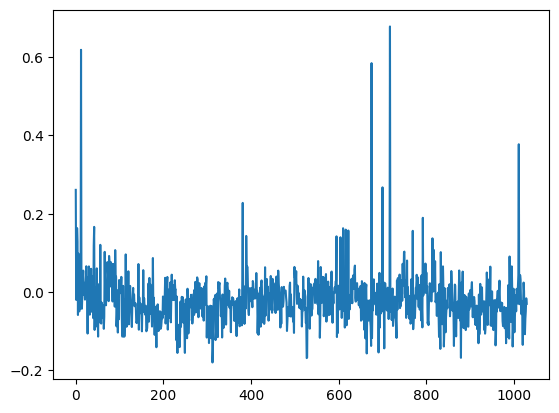

In [37]:
loo = az.loo(inference_data, pointwise=True)
pareto_k = loo.pareto_k
bad_pareto_indices = np.where(pareto_k > 0.5)[0]
bad_pareto_values = pareto_k[bad_pareto_indices].values  
print("Bad Pareto k indices:", bad_pareto_indices)
print("Bad Pareto k values:", bad_pareto_values)
print("Outlier values:", concrete_strengths[bad_pareto_indices])

plt.plot(loo.pareto_k)

# Emprirical CDF

In [34]:
def evaluate_ecdf(trace: az.InferenceData) -> np.array:
    """Evaluates ECDF at original observed values.

    This function assumes a single set of observed values.

    Args:
        trace: arviz.InferenceData from running a PyMC model.

    Returns:
        A Numpy array of the ECDF evaluation at each original datapoint.
    """
    # get posterior predictive variable name
    ppc_vars = list(trace.posterior_predictive.data_vars)
    assert (
        len(ppc_vars) == 1
    ), "Number of variables in posterior predictive must equal 1."
    y_varname = ppc_vars[0]

    # get original observations
    y_obs = trace.observed_data[y_varname].values
    assert len(y_obs.shape) == 1, "y-observations shape must be one-dimensional."
    n_obs = y_obs.shape[0]
    y_obs = y_obs.reshape((-1, 1))  # for broadcasting

    # get posterior predictive samples for each y_obs and sample count
    y_samples_per_obs = trace.posterior_predictive[y_varname].stack(
        sample=("chain", "draw")
    )
    
    assert y_samples_per_obs.shape[0] == n_obs, "Shape assumptions aren't met."
    n_samples = y_samples_per_obs.shape[1]

    # evaluate ECDF at each y_obs and convert to numpy array
    ecdf_values = y_samples_per_obs < y_obs
    prob = ecdf_values.sum(dim="sample") / n_samples

    return prob.to_numpy()


Non-finite sq_logit indices: [   0   12  381  675  700  717 1011]
Outlier values: [134.43 139.12 120.34 124.53 101.45 134.83 132.45]


/var/folders/73/f0n3k1fs4jv_p0qmp65qlzkh0000gn/T/ipykernel_58598/2206158529.py:2: RuntimeWarning: divide by zero encountered in true_divide
  sq_logit = np.log(prob / (1 - prob)) ** 2


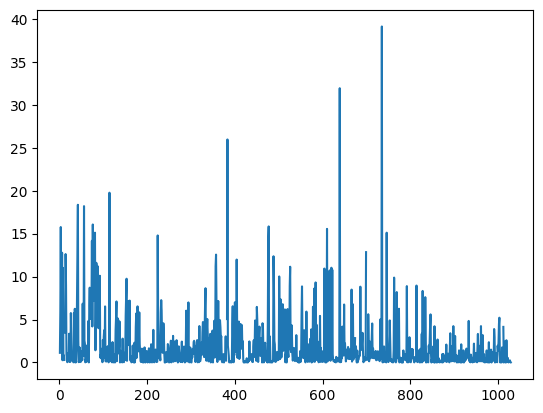

In [36]:
prob = evaluate_ecdf(inference_data)
sq_logit = np.log(prob / (1 - prob)) ** 2

# Identify non-finite values which may indicate outliers
non_finite_indices = np.where(~np.isfinite(sq_logit))[0]
print("Non-finite sq_logit indices:", non_finite_indices)
print("Outlier values:", concrete_strengths[non_finite_indices])

# Plot the squared logit
plt.plot(sq_logit)

# Outlier Anyalsis

### Using Pareto K Diagnostic Values, 

3 values were found to be above the 0.5 threshold.

Bad Pareto k indices: `[12, 675, 717]`

Bad Pareto k values: `[0.6175269,  0.53365982, 0.61547244]`

Outlier concrete strength values: `[139.12, 124.53, 134.83]`

### Using Empirical CDF

Outlier indices: `[0, 12, 381, 675, 700, 717, 1011]`

Outlier concrete strength values: `[134.43, 139.12, 120.34, 124.53, 101.45, 134.83, 132.45]`

### Comments
The outliers detected are not the same for both methods: those detected using the pareto k methodology are subset of those detected using the empirical CDF methodology.